### 1. Optical Flow with Lucas-Kanade method

<ipython-input-6-30f2bd21ff7a>:67: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.line(mask, (a, b), (c, d),
<ipython-input-6-30f2bd21ff7a>:70: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  frame = cv2.circle(frame, (a, b), 5,


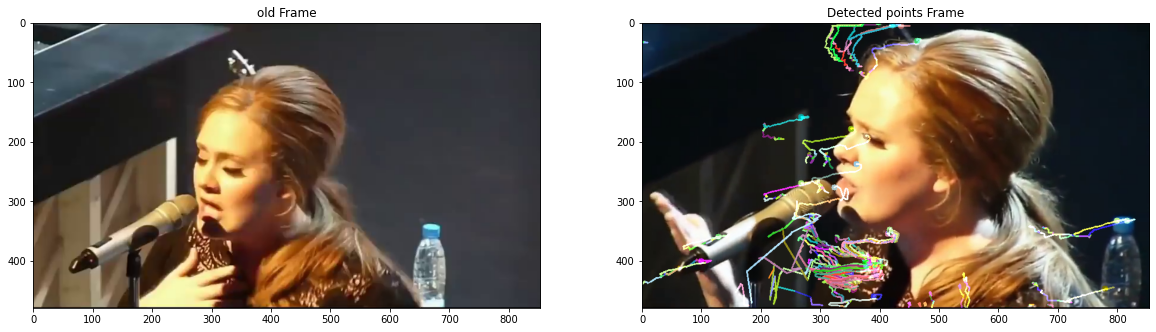

In [6]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
 
# To capture video from webcam. 
# cv2.VideoCapture(index or file_name)    
cap = cv2.VideoCapture('Data/music.mp4') 
  
# params for corner detection 
feature_params = dict( maxCorners = 100, 
                       qualityLevel = 0.3, 
                       minDistance = 7, 
                       blockSize = 7 ) 
  
# Parameters for lucas kanade optical flow 
lk_params = dict( winSize = (15, 15), 
                  maxLevel = 2, 
                   # cv2.TERM_CRITERIA_COUNT: maximum number of iterations criteria.maxCount 
                  # cv2.TERM_CRITERIA_EPS: when the search window moves by less than criteria.epsilon.
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                              10, 0.03)) 
  
# Create some random colors 
color = np.random.randint(0, 255, (100, 3)) 
  
# Take first frame and find corners in it 
ret, old_frame = cap.read() 
old_frame_rgb = cv2.cvtColor(old_frame, cv2.COLOR_BGR2RGB) 
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY) 

# Shi-Tomasi corner detection function 
# We are detecting only 100 best corners here 
# cv2.goodFeaturesToTrack(gray_img, max-corners, Quality-level , Minmum-distance, blockSize, useHarrisDetector)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params) 
  
# Create a mask image for drawing purposes 
# np.zeros_like(a, dtype=None, order='K', subok=True, shape=None)
# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(old_frame) 
  
while(True): 
      
    # Read the frame
    # retval, image = cv.VideoCapture.read(image)    
    ret, frame = cap.read() 
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    # calculate optical flow 
    # cv.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts, status, err,
    #                         winSize, maxLevel, criteria, flags, minEigThreshold)
    # nextPts, status(0 or 1), err
    '''
     prevImg : first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid.
     nextImg : second input image or pyramid of the same size and the same type as prevImg.
     prevPts : vector of 2D points for which the flow needs to be found
     nextPts : output vector of 2D points containing the calculated new positions of input
               features in the second image
     status  : - output status vector (of unsigned chars).
               - each element of the vector is set to 1 if the flow for the corresponding features has been found,
               - otherwise, it is set to 0.
     err     : - output vector of errors;
               - each element of the vector is set to an error for the corresponding feature,
               - type of the error measure can be set in flags parameter.
               - if the flow wasn't found then the error is not defined.
     winSize : size of the search window at each pyramid level.
     maxLevel: - 0-based maximal pyramid level number; 
               - if set to 0, pyramids are not used (single level),
               - if set to 1, two levels are used, and so on
               - if pyramids are passed to input then algorithm will use as many levels as pyramids have but no more than maxLevel.
     criteria: parameter, specifying the termination criteria of the iterative search algorithm 
     flags   : operation flags:
    '''
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, 
                                           frame_gray, 
                                           p0, None, 
                                           **lk_params) 
  
    # Select good points 
    good_new = p1[st == 1] 
    good_old = p0[st == 1] 
  
    # draw the tracks 
    for i, (new, old) in enumerate(zip(good_new,  
                                       good_old)): 
        # np.ravel(array, order = ‘C’)
        # returns contiguous flattened array(1D array with all the input-array 
        #                                    elements and with the same type as it)
        a, b = new.ravel() 
        c, d = old.ravel() 
        # cv2.line(image, start_point, end_point, color, thickness)
        mask = cv2.line(mask, (a, b), (c, d), 
                        color[i].tolist(), 2) 
        # cv2.circle(image, center pt, radius, color, thickness)  
        frame = cv2.circle(frame, (a, b), 5, 
                           color[i].tolist(), -1) 
        
    # cv2.add(src1, src2, dst, mask, dtype)
    img = cv2.add(frame, mask) 
  
    cv2.imshow('frame', img) 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
    k = cv2.waitKey(25) 
    if k == 27: 
        break
  
    # Updating Previous frame and points  
    old_gray = frame_gray.copy() 
    p0 = good_new.reshape(-1, 1, 2) 
    
cv2.destroyAllWindows() 
cap.release() 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('old Frame')
ax1.imshow(old_frame_rgb)
ax2.set_title('Detected points Frame')
ax2.imshow(img_rgb)

### 2. Dense optical flow - The Gunnar-Farneback Algorithm

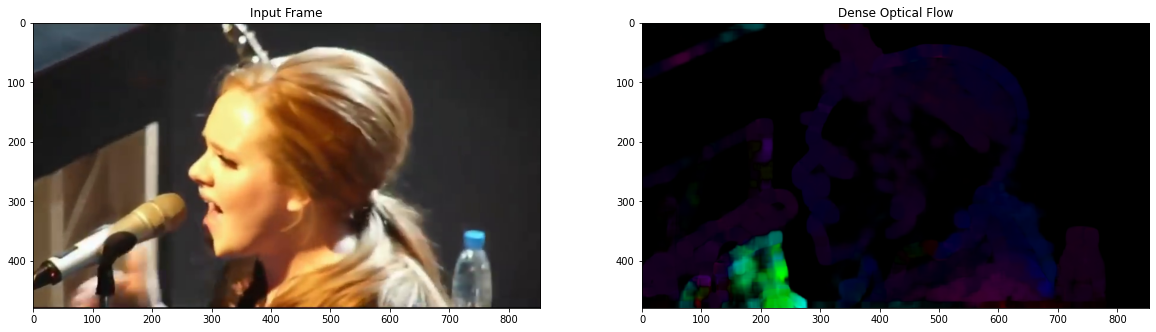

In [5]:
import cv2  
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

# The video feed is read in as 
# a VideoCapture object 
cap = cv2.VideoCapture('Data/music.mp4') 
  
# ret = a boolean return value from 
# getting the frame, first_frame = the 
# first frame in the entire video sequence 
ret, first_frame = cap.read() 
  
# Converts frame to grayscale because we 
# only need the luminance channel for 
# detecting edges - less computationally  
# expensive 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) 
  
# Creates an image filled with zero 
# intensities with the same dimensions  
# as the frame 
mask = np.zeros_like(first_frame) 
  
# Sets image saturation to maximum 
mask[..., 1] = 255
  
while(cap.isOpened()): 
      
    # ret = a boolean return value from getting 
    # the frame, frame = the current frame being 
    # projected in the video 
    ret, frame = cap.read() 
      
    # Opens a new window and displays the input 
    # frame 
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow("Input Frame", frame) 
      
    # Converts each frame to grayscale - we previously  
    # only converted the first frame to grayscale 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Calculates dense optical flow by Farneback method 
    # cv.calcOpticalFlowFarneback(prev, next, flow, pyr_scale,pyramids_levels, winsize,
    #                             iterations, poly_n, poly_sigma, flags)
    '''
    pyr_scale : parameter, specifying the image scale (<1) to build pyramids for each image
    poly_n    : - size of the pixel neighborhood used to find polynomial expansion in each pixel.
                - larger values mean that the image will be approximated with smoother surfaces
    poly_sigma: - standard deviation of the Gaussian that is used to smooth derivatives  
                - for poly_n=5, you can set poly_sigma=1.1
                - for poly_n=7, a good value would be poly_sigma=1.5.
    '''
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,  
                                       None, 
                                       0.5, 3, 15, 3, 5, 1.2, 0) 
      
    # Computes the magnitude and angle of the 2D vectors 
    # cv2.cartToPolar(x, y, magnitude, angle, angleInDegrees)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
      
    # Sets image hue according to the optical flow  
    # direction 
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow 
    # magnitude (normalized) 
    # dst = cv2.normalize(src, dst, alpha, beta, norm_type, dtype, mask)
    # a way that the min value of dst is alpha and max value of dst is beta
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) 
      
    # Converts HSV to RGB (BGR) color representation 
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) 
    rgb_frame = cv2.cvtColor(mask, cv2.COLOR_HSV2RGB) 
      
    # Opens a new window and displays the output frame 
    cv2.imshow("dense optical flow", rgb) 
      
    # Updates previous frame 
    prev_gray = gray 
      
    # Frames are read by intervals of 1 millisecond. The 
    # programs breaks out of the while loop when the 
    # user presses the 'q' key 
    k = cv2.waitKey(25) 
    if k == 27: 
        break
        
# The following frees up resources and 
# closes all windows 
cap.release() 
cv2.destroyAllWindows() 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Input Frame')
ax1.imshow(frame_rgb)
ax2.set_title('Dense Optical Flow')
ax2.imshow(rgb_frame)

### 3. Visualizing image in different color spaces

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


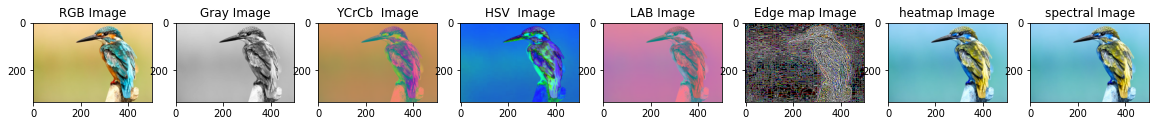

In [11]:
import cv2 
import matplotlib.pyplot as plt 
get_ipython().run_line_magic('matplotlib', 'inline')

# import matplotlib.image as mpimg
# img = mpimg.imread('Data/bird.jpeg')
  
# reads image as RGB 
img = cv2.imread('Data/bird.jpeg') 
# Convert image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert image to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# Convert image to YCrCb 
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# Convert image to HSV 
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
# Converts image to LAB  
img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
# Convert image to Edge map 
img_laplacian = cv2.Laplacian(img, cv2.CV_64F)
# Convert image to heatmap
# plt.imshow(img, cmap ='hot')
# Convert image to spectral
# plt.imshow(img, cmap ='nipy_spectral')  
  
# shows the image 
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(20,20))
ax1.set_title('RGB Image')
ax1.imshow(img_rgb)
ax2.set_title('Gray Image')
ax2.imshow(img_gray, cmap='gray')
ax3.set_title('YCrCb  Image')
ax3.imshow(img_YCrCb)
ax4.set_title('HSV  Image')
ax4.imshow(img_HSV)
ax5.set_title('LAB Image')
ax5.imshow(img_LAB)
ax6.set_title('Edge map Image')
ax6.imshow(img_laplacian)
ax7.set_title('heatmap Image')
ax7.imshow(img, cmap ='hot')
ax8.set_title('spectral Image')
ax8.imshow(img, cmap ='nipy_spectral')


### 4. Find Co-ordinates of Contours

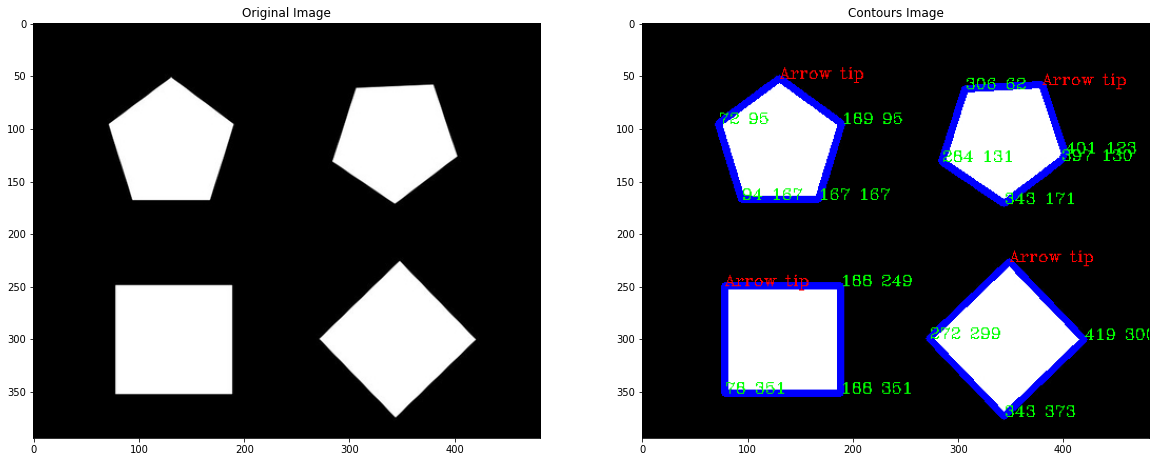

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
%matplotlib inline
   
# Reading image 
font = cv2.FONT_HERSHEY_COMPLEX 
img = cv2.imread('Data/find_contours.jpg') 

# Convert image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# Copy image to draw boundary of contours on it
img_rgb_copy = np.copy(img_rgb)
# Convert image to GRAY 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
# Converting image to a binary image 
# ( black and white only image). 
# retval, dst = cv.threshold(src, thresh, maxval, threshold_type)
_, threshold = cv2.threshold(img_gray, 110, 255, cv2.THRESH_BINARY) 
  
# Detecting contours in image. 
# image, contours, hierarchy = cv.findContours(mode, method, offset)

# hierarchy: containing information about the image topology.

# RETR_TREE : retrieves all of the contours and reconstructs a full hierarchy of nested contours.
# CHAIN_APPROX_SIMPLE : compresses horizontal, vertical, and diagonal segments and leaves only their end points.
# offset : Optional offset by which every contour point is shifted.
contours, _= cv2.findContours(threshold, cv2.RETR_TREE, 
                              cv2.CHAIN_APPROX_SIMPLE) 
  
# Going through every contours found in the image. 
for cnt in contours :
    
    # approxCurve = cv.approxPolyDP(curve, epsilon, closed)
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
  
    # draws boundary of contours. 
    # image = cv.drawContours(image_to_draw, contours, contourIdx, color, thickness,
    #                         lineType, hierarchy, maxLevel, offset)

    cv2.drawContours(img_rgb_copy, [approx], 0, (0, 0, 255), 5)  
  
    # Used to flatted the array containing 
    # the co-ordinates of the vertices. 
    n = approx.ravel()  
    i = 0
  
    for j in n : 
        if(i % 2 == 0): 
            x = n[i] 
            y = n[i + 1] 
  
            # String containing the co-ordinates. 
            string = str(x) + " " + str(y)  
  
            if(i == 0): 
                # text on topmost co-ordinate. 
                cv2.putText(img_rgb_copy, "Arrow tip", (x, y), 
                                font, 0.5, (255, 0, 0))  
            else: 
                # text on remaining co-ordinates. 
                cv2.putText(img_rgb_copy, string, (x, y),  
                          font, 0.5, (0, 255, 0))  
        i = i + 1
        
# cv2.imshow('Contours Image', img_rgb_copy)  
  
# # Exiting the window if 'q' is pressed on the keyboard. 
# if cv2.waitKey(0) & 0xFF == ord('q'):  
#     cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img_rgb)
ax2.set_title('Contours Image')
ax2.imshow(img_rgb_copy)    

### 5. Find and Draw Contours

Number of Contours found = 2


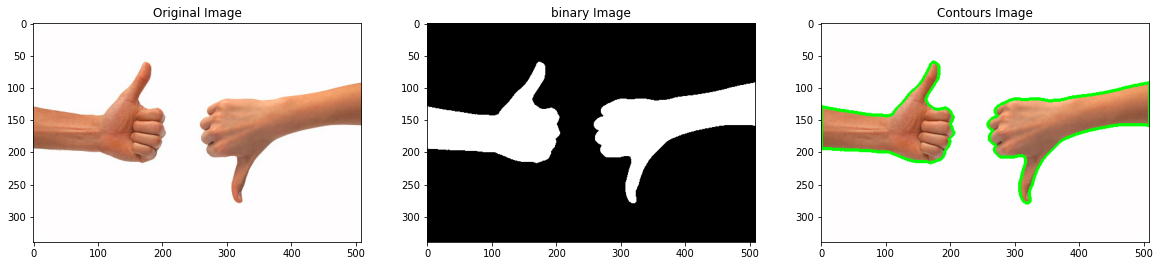

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
  
# Read image
img = cv2.imread('Data/hand.jpg') 
  
# convert image to RGB 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

# make a copy of image 
img_rgb_copy = np.copy(img_rgb)

# convert image to Grayscale 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
# Create a binary thresholded image
retval, binary = cv2.threshold(img_gray, 225, 255, cv2.THRESH_BINARY_INV)
  
# Finding Contours 
# Use a copy of the image e.g. edged.copy() 
# since findContours alters the image 
# image, contours, hierarchy = cv.findContours(image, mode, method, contours, hierarchy, offset)
contours, hierarchy = cv2.findContours(binary,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
  
print("Number of Contours found = " + str(len(contours))) 
  
# Draw all contours 
# -1 signifies drawing all contours 
cv2.drawContours(img_rgb_copy, contours, -1, (0, 255, 0), 3) 
  
cv2.imshow('Contours', img_rgb_copy) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img_rgb)
ax2.set_title('binary Image')
ax2.imshow(binary, cmap="gray")    
ax3.set_title('Contours Image')
ax3.imshow(img_rgb_copy)    

### 6. Draw a rectangular shape and extract objects

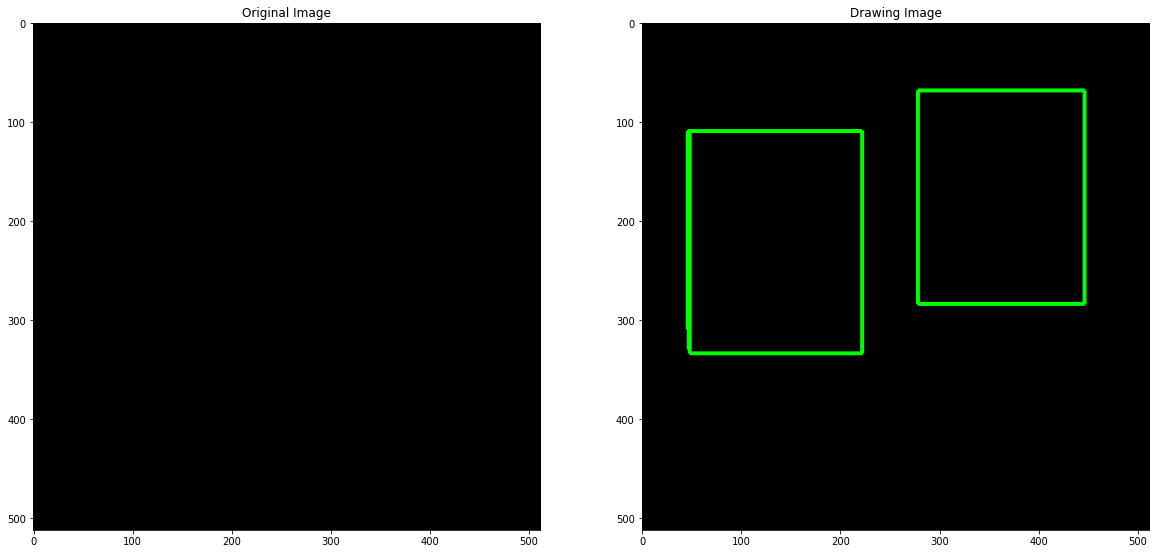

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
  
drawing = False     # true if mouse is pressed 
mode = True         # if True, draw rectangle. 
ix, iy = -1, -1
  
# mouse callback function 
def draw_circle(event, x, y, flags, param): 
    global ix, iy, drawing, mode 
    
    # cv.EVENT_LBUTTONDOWN --> indicates that the left mouse button is pressed.  
    if event == cv2.EVENT_LBUTTONDOWN: 
        drawing = True
        ix, iy = x, y 
    # cv.EVENT_MOUSEMOVE --> indicates that the mouse pointer has moved over the window.  
    elif event == cv2.EVENT_MOUSEMOVE: 
        if drawing == True: 
            if mode == True: 
                cv2.rectangle(img_copy, (ix, iy), (x, y), (0, 255, 0), 3) 
                a = x 
                b = y 
                if a != x | b != y: 
                    # img = cv.rectangle(img, pt1, pt2, color, thickness, lineType, shift)
                    # -1 --> mean that the function has to draw a filled rectangle.
                    cv2.rectangle(img_copy, (ix, iy), (x, y), (0, 0, 0), -1) 
            else: 
                # cv2.circle(image, center_coordinates, radius, color, thickness)
                cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1) 
                
    # cv.EVENT_LBUTTONUP --> indicates that left mouse button is released.  
    elif event == cv2.EVENT_LBUTTONUP: 
        drawing = False
        if mode == True: 
            cv2.rectangle(img_copy, (ix, iy), (x, y), (0, 255, 0), 2) 
      
        else: 
            cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1) 
            
img = np.zeros((512, 512, 3), np.uint8) 

img_copy = np.copy(img)
# cv.namedWindow(win_name, flags)
cv2.namedWindow('image') 
cv2.setMouseCallback('image', draw_circle) 
  
while(1): 
    cv2.imshow('image', img_copy) 
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'): 
        mode = not mode 
    elif k == 27: 
        break 
cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Drawing Image')
ax2.imshow(img_copy)   

In [13]:
# import cv2 
# import numpy as np
# import matplotlib.pyplot as plt 
# %matplotlib inline
  
# # now let's initialize the list of reference point 
# ref_point = [] 
# crop = False
  
# def shape_selection(event, x, y, flags, param): 
#     # grab references to the global variables 
#     global ref_point, crop 
  
#     # if the left mouse button was clicked, record the starting 
#     # (x, y) coordinates and indicate that cropping is being performed 
#     if event == cv2.EVENT_LBUTTONDOWN: 
#         ref_point = [(x, y)] 
  
#     # check to see if the left mouse button was released 
#     elif event == cv2.EVENT_LBUTTONUP: 
#         # record the ending (x, y) coordinates and indicate that 
#         # the cropping operation is finished 
#         ref_point.append((x, y)) 
  
#         # draw a rectangle around the region of interest 
#         cv2.rectangle(img_rgb_copy, ref_point[0], ref_point[1], (0, 255, 0), 3) 
# #         cv2.imshow("image", img_rgb_copy) 
  
# # # construct the argument parser and parse the arguments 
# # ap = argparse.ArgumentParser() 
# # ap.add_argument("-i", "--image", required = True, help ="Path to the image") 
# # args = vars(ap.parse_args()) 
  
# # load the image, clone it, and setup the mouse callback function 
# img = cv2.imread('Data/bird.jpeg') 
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img_rgb_copy = np.copy(img_rgb)

# clone = np.copy(img_rgb) 

# cv2.namedWindow("image") 
# cv2.setMouseCallback("image", shape_selection) 
   
# # keep looping until the 'q' key is pressed 
# # while True: 
# #     # display the image and wait for a keypress 
# #     cv2.imshow("image", img) 
# #     key = cv2.waitKey(1) & 0xFF
  
# #     # press 'r' to reset the window 
# #     if key == ord("r"): 
# #         image = clone.copy() 
  
# #     # if the 'c' key is pressed, break from the loop 
# #     elif key == ord("c"): 
# #         break

# # Displaying the image  
# cv2.imshow("image", img_rgb_copy) 
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 
        
# # when two points were found        
# if len(ref_point) == 2: 
#     crop_img = clone[ref_point[0][1]:ref_point[1][1], ref_point[0][0]: 
#                                                            ref_point[1][0]] 
#     cv2.imshow("crop_img", crop_img) 
#     cv2.waitKey(0) 
    
# # # close all open windows 
# # cv2.destroyAllWindows()

# # Showing the final image. 
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
# ax1.set_title('Original Image')
# ax1.imshow(img_rgb)
# ax2.set_title('Drawing Rect')
# ax2.imshow(img_rgb_copy) 
# ax3.set_title('Croping Image')
# ax3.imshow(crop_img) 

roi0:  163
roi1:  2
roi2:  268
roi3:  153


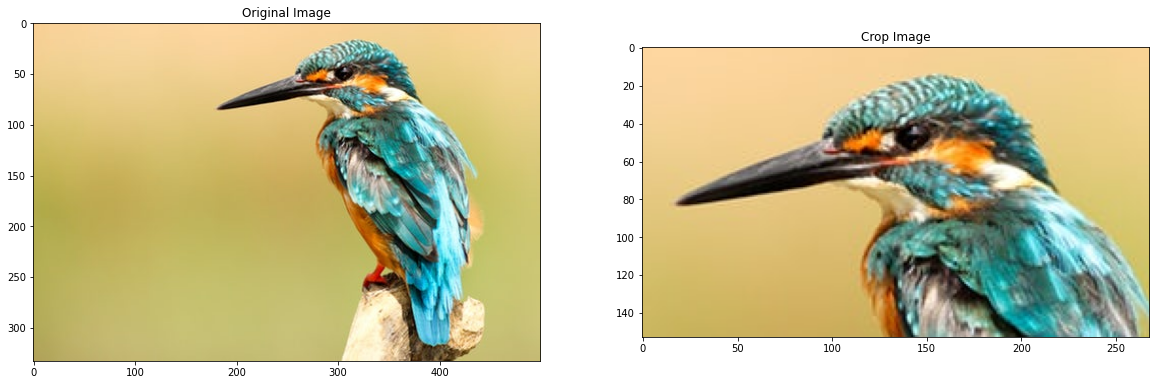

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

# Read image
img = cv2.imread('Data/bird.jpeg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb_copy = np.copy(img_rgb)

# Select ROI
# retval = cv.selectROI(windowName, img, showCrosshair, fromCenter)
roi = cv2.selectROI(img_rgb_copy)

print("roi0: ",roi[0])
print("roi1: ",roi[1])
print("roi2: ",roi[2])
print("roi3: ",roi[3])


# Crop image
imCrop = img_rgb_copy[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

# Displaying cropped image 
cv2.imshow("Image", imCrop) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img_rgb)
ax2.set_title('Crop Image')
ax2.imshow(imCrop)     

### 7. cv2.rectangle() method

  - Syntax: cv2.rectangle(image, start_point, end_point, color, thickness)

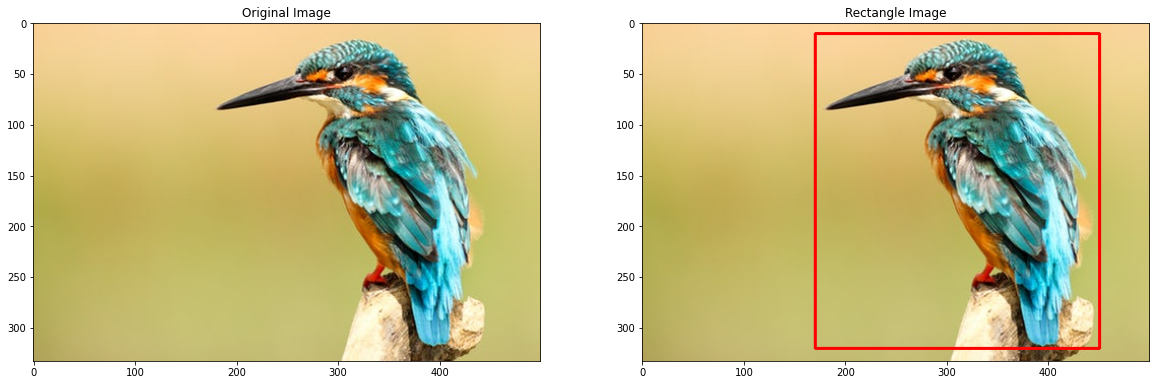

In [11]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

   
# Reading an image in default mode 
img = cv2.imread('Data/bird.jpeg') 

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb_copy = np.copy(img_rgb)
   
# Window name in which image is displayed 
window_name = 'Image'
  
# Start coordinate, here (5, 5) 
# represents the top left corner of rectangle 
start_point = (170, 10) 
  
# Ending coordinate, here (220, 220) 
# represents the bottom right corner of rectangle 
end_point = (450, 320) 
  
# Red color in RGB 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2 

# Using cv2.rectangle() method 
# Draw a rectangle with blue line borders of thickness of 2 px 
# cv2.rectangle(image, start_point, end_point, color, thickness)
image = cv2.rectangle(img_rgb_copy, start_point, end_point, color, thickness) 
  
# Displaying the image  
cv2.imshow(window_name, image) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img_rgb)
ax2.set_title('Rectangle Image')
ax2.imshow(img_rgb_copy)      

### 8. cv2.putText() method

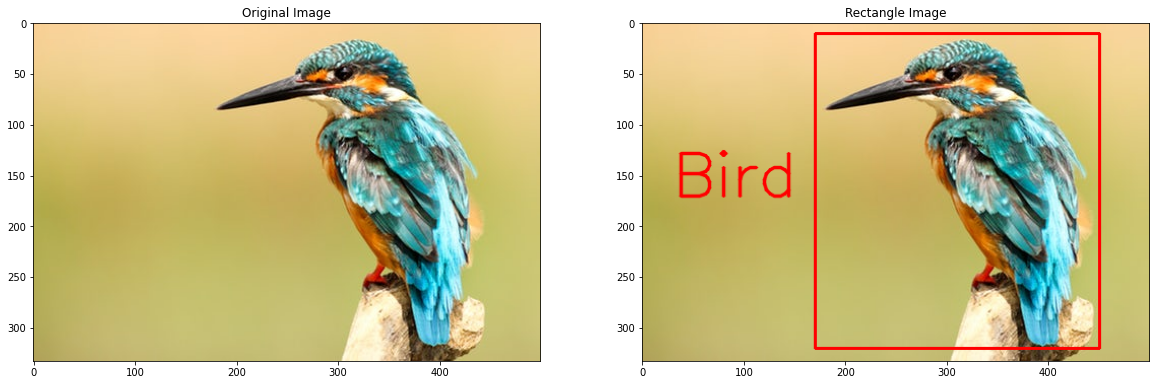

In [9]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
    
# Reading an image in default mode 
img = cv2.imread('Data/bird.jpeg') 

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb_copy = np.copy(img_rgb)
    
# Window name in which image is displayed 
window_name = 'Image'
  
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org
org = (30, 170) 
  
# fontScale 
fontScale = 2
   
# Red color in RGB 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2
  
image = cv2.rectangle(img_rgb_copy, (170, 10), (450, 320) , (255, 0, 0) , 2)

# Using cv2.putText() method 
image_text = cv2.putText(image, 'Bird', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
   
# Displaying the image  
cv2.imshow(window_name, image) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

# Showing the final image. 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(img_rgb)
ax2.set_title('Rectangle Image')
ax2.imshow(image) 